In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
from keras.callbacks import EarlyStopping

Abrindo dataset

In [8]:
df = pd.read_csv("dataset/spam.csv",delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Removendo colunas sem uso

In [9]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Distribuição das mensagens

Text(0.5, 1.0, 'Mensagens x Spams')

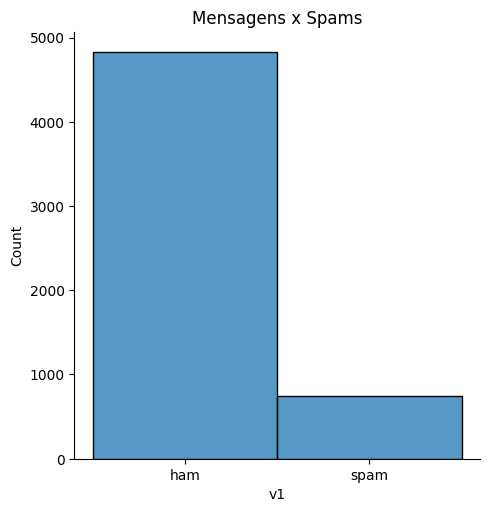

In [37]:
sns.displot(df.v1)
plt.title('Mensagens x Spams')

Criando encoders

In [38]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
print('Y shape: ', Y.shape)
print('Y unique values: ', np.unique(Y))

Y shape:  (5572, 1)
Y unique values:  [0 1]


Separando dados de teste

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, stratify = Y)

Processando dados

In [46]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

RNN

In [47]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,128,input_length=max_len)(inputs)
    # Embedding (input_dim: size of vocabolary, 
    # output_dim: dimension of dense embedding, 
    # input_length: length of input sequence)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [48]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 128)          128000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

Treinando o modelo

In [49]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 18s 446ms/step - loss: 0.4141 - accuracy: 0.8495 - val_loss: 0.1782 - val_accuracy: 0.9230
Epoch 2/10
30/30 [==============================] - 9s 305ms/step - loss: 0.1035 - accuracy: 0.9702 - val_loss: 0.0640 - val_accuracy: 0.9810
Epoch 3/10
30/30 [==============================] - 10s 321ms/step - loss: 0.0388 - accuracy: 0.9884 - val_loss: 0.0492 - val_accuracy: 0.9842
Epoch 4/10
30/30 [==============================] - 13s 434ms/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0531 - val_accuracy: 0.9842


Testando

In [50]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

Avaliando metricas

In [57]:
acuracia = model.evaluate(test_sequences_matrix,Y_test)
print(f"acurancia: {acuracia[1] * 100}%")

27/27 [==============================] - 1s 34ms/step - loss: 0.0551 - accuracy: 0.9833
acurancia: 98.32535982131958%
